In [2]:
import os
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


with open('.env') as f:
    openai.api_key = f.read().strip().split('=')[1]

anthems_dir = Path('data/anthems')
file_paths = {}
lyrics = {}
embeddings = {}


for g in anthems_dir.glob('*.txt'):
    stem = g.stem
    file_paths[stem] = g
    
    with open(g) as f:
        lyrics[stem] = np.asarray([line.strip() for line in f.readlines() if line.strip() != ""])

    emb_path = g.with_suffix('.emb')
    if os.path.isfile(emb_path):
        embeddings[stem] = np.loadtxt(emb_path)
    else:
        response = openai.Embedding.create(input=list(lyrics[stem]), model="text-embedding-ada-002")
        embeddings[stem] = np.asarray([e.embedding for e in response['data']])
        np.savetxt(emb_path, embeddings[stem])

In [66]:
def correlate(e1, e2=None):
    if e2 is None:
        e2 = e1
    return e1 @ e2.T

def correlate_minus_diag(e1):
    correlation = e1 @ e1.T
    return correlation - (1 - correlation.mean()) * np.eye(correlation.shape[0])

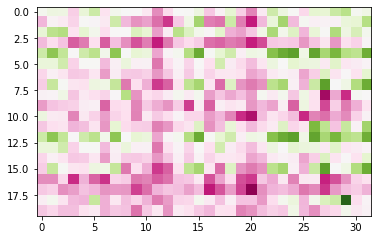

In [56]:
plt.imshow(correlate(embeddings['RUS'], embeddings['USA']), cmap='PiYG')

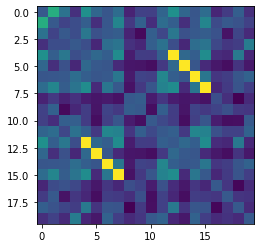

In [68]:
plt.imshow(correlate_minus_diag(embeddings['RUS']))

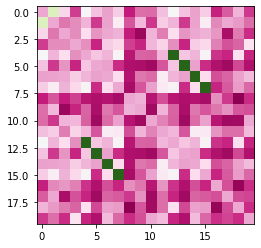

In [229]:
remove_diag = (rus_embed @ rus_embed.T) - (1 - (rus_embed @ rus_embed.T).mean()) * np.eye(rus_array.shape[0])
plt.imshow(remove_diag, cmap='PiYG')

In [241]:
rus_array[(rus_embed @ rus_embed.mean(axis=0)).argsort()[:10]]

array(['От южных морей до полярного края', 'Грядущие нам открывают года.',
       'Широкий простор для мечты и для жизни',
       'Одна ты на свете! Одна ты такая –',
       'Раскинулись наши леса и поля.',
       'Так было, так есть и так будет всегда!',
       'Нам силу даёт наша верность Отчизне.',
       'Братских народов союз вековой,', 'Братских народов союз вековой,',
       'Могучая воля, великая слава –'], dtype='<U38')

In [208]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)

kmeans.fit(embeddings)
labels = kmeans.labels_

In [210]:
df = pd.DataFrame({'lyric': usa_array, 'cluster': labels})
df

,lyric,cluster
0,"O say can you see, by the dawn's early light,",2
1,What so proudly we hailed at the twilight's la...,2
2,Whose broad stripes and bright stars through t...,3
3,"O'er the ramparts we watched, were so gallantl...",2
4,"And the rocket's red glare, the bombs bursting...",2
5,Gave proof through the night that our flag was...,2
6,O say does that star-spangled banner yet wave,3
7,O'er the land of the free and the home of the ...,0
8,On the shore dimly seen through the mists of t...,1
9,Where the foe's haughty host in dread silence ...,1


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

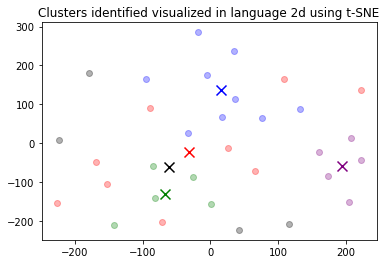

In [217]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(embeddings)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "black"]):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

In [220]:
rev_per_cluster = 4

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    lyrics = "\n".join(
        df[df.cluster == i]
        .lyric
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following lyrics have in common?\n\nLyrics:\n"""\n{lyrics}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.lyric.values[j])

    print("-" * 100)

Cluster 0 Theme:  The land of the free and the home of the brave.
O'er the land of the free and the home of the brave.
O'er the land of the free and the home of the brave!
A home and a country, should leave us no more?
O'er the land of the free and the home of the brave?
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  The power of nature
Where the foe's haughty host in dread silence reposes,
From the terror of flight, or the gloom of the grave:
What is that which the breeze, o'er the towering steep,
On the shore dimly seen through the mists of the deep,
----------------------------------------------------------------------------------------------------
Cluster 2 Theme:  The American Revolution
And where is that band who so vauntingly swore
What so proudly we hailed at the twilight's last gleaming,
Now it catches the gleam of the morning's first beam,
O say can you see, by the dawn's early light,
--------------------